In [2]:
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive
import itertools
import hashlib
from scipy.stats import poisson, norm, gamma
#!pip install pymc3
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
#import bambi as bmb # was not used?
sns.set(style="dark")
plt.style.use("ggplot")

try:
    from pymc3 import *
    import pymc3 as pm
except:
    ! pip install pymc3
    from pymc3 import *
    import pymc3 as pm

import arviz as az

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 14.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 34.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.6/260.6 kB 24.7 MB/s eta 0:00:00
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=7633479a4802a4fc05ad4a404c48dd2b013e986439a2450e7ba3aaac78a3dacd
  Stored in directory: /Users/daniel/Library/Caches/pip/wheels/04/22/4d/832878ba2fe9ea3543f0189b9288a78

ContextualVersionConflict: (scipy 1.9.1 (/opt/anaconda3/lib/python3.9/site-packages), Requirement.parse('scipy<1.8.0,>=1.7.3'), {'pymc3'})

# Modeling Highway Fatalities

In [3]:
url = "https://data.bts.gov/resource/crem-w557.json"
r = requests.get(url)
data = pd.DataFrame(r.json())
mob_data = data.drop(['index'], axis = 1)
date_dict = {'01': 'Jan',
             '02': 'Feb',
             '03': 'Mar',
             '04': 'Apr',
             '05': 'May',
             '06': 'Jun',
             '07': 'Jul',
             '08': 'Aug',
             '09': 'Sep',
             '10': 'Oct',
             '11': 'Nov',
             '12': 'Dec'}

fatalities = mob_data[~mob_data['safety_highway_fatalities_1'].isna()]
fatalities = fatalities[['date','safety_highway_fatalities_1','highway_fuel_prices_regular', 'transportation_economic_3', 
                         'transportation_economic_2', 'general_economic_indicators_2',
                         'auto_sales', 'capital_expenditures_state_47']]
fatalities.columns = ['date', 'fatalities', 'gas_price', 'truck_employ', 'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending']
fatalities['month'] = fatalities['date'].apply(lambda x: x[5:7])
fatalities['month'] = fatalities['month'].map(date_dict)
fatalities = fatalities.join(pd.get_dummies(fatalities.month, prefix='month'))
fatalities['highway_spending'] = fatalities['highway_spending'].apply(lambda x: float(x)) / 10000000

fatalities['gas_price'] = fatalities['gas_price'].apply(lambda x: float(x))
fatalities['truck_employ'] = fatalities['truck_employ'].apply(lambda x: float(x))
fatalities['pers_spend'] = fatalities['pers_spend'].apply(lambda x: float(x))
fatalities['lab_force_partic'] = fatalities['lab_force_partic'].apply(lambda x: float(x))
fatalities['auto_sales'] = fatalities['auto_sales'].apply(lambda x: float(x))
fatalities['fatalities'] = fatalities['fatalities'].apply(lambda x: float(x)) * 100
fatalities.head()

,date,fatalities,gas_price,truck_employ,pers_spend,lab_force_partic,auto_sales,highway_spending,month,month_Apr,month_Jan,month_Jul,month_Oct
732,2008-01-01T00:00:00.000,122.0,3.043,1391900.0,3.535940e+11,0.662,495800.0,368.4,Jan,0,1,0,0
735,2008-04-01T00:00:00.000,125.0,3.458,1394400.0,3.491970e+11,0.659,656800.0,577.4,Apr,1,0,0,0
738,2008-07-01T00:00:00.000,133.0,4.062,1404300.0,3.432790e+11,0.661,618800.0,880.5,Jul,0,0,1,0
741,2008-10-01T00:00:00.000,132.0,3.051,1386800.0,3.313030e+11,0.660,427100.0,854.5,Oct,0,0,0,1
744,2009-01-01T00:00:00.000,109.0,1.788,1287600.0,3.233560e+11,0.657,312700.0,376.9,Jan,0,1,0,0


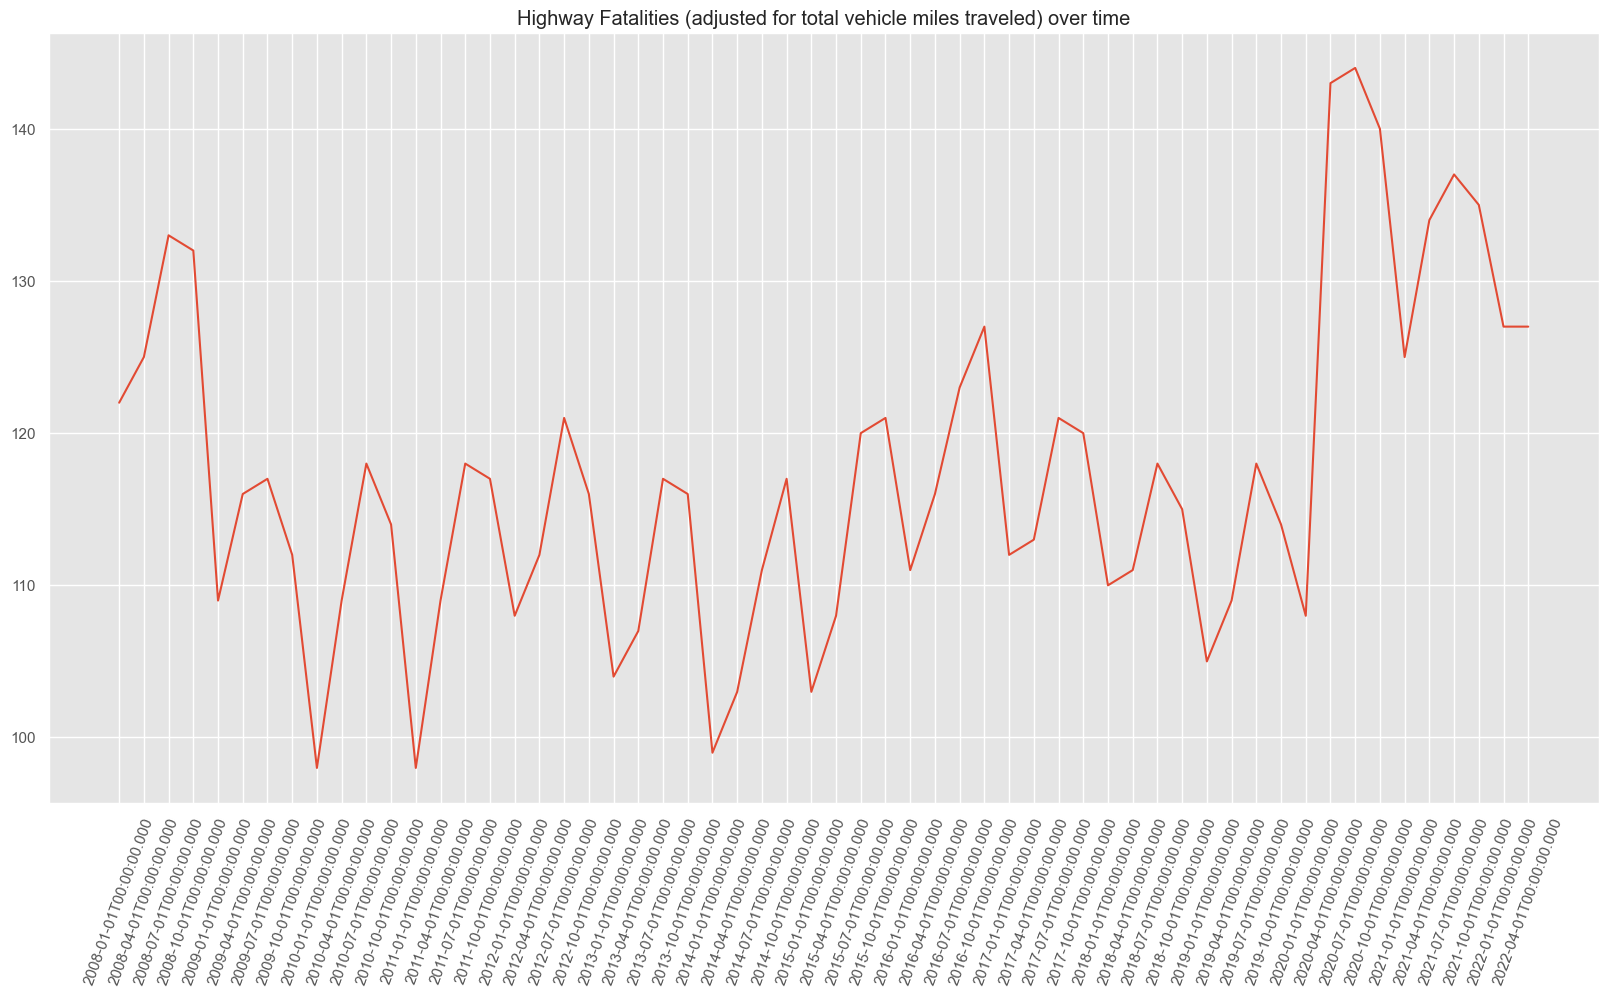

In [4]:
plt.figure(figsize=(20, 10))
plt.plot(fatalities['date'], fatalities["fatalities"].apply(lambda x: float(x)))
plt.title("Highway Fatalities (adjusted for total vehicle miles traveled) over time")
plt.xticks(rotation=70);

In [5]:
X = fatalities[['gas_price', 'truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']]
y = fatalities['fatalities']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
model_test = X_train.join(y_train)
model_test['month_Apr'] = np.sin(model_test['month_Apr'])
model_test['month_Jan'] = np.sin(model_test['month_Jan'])
model_test['month_Jul'] = np.sin(model_test['month_Jul'])
model_test['month_Oct'] = np.sin(model_test['month_Oct'])

model_test.head()

,gas_price,truck_employ,pers_spend,lab_force_partic,auto_sales,highway_spending,month_Apr,month_Jan,month_Jul,month_Oct,fatalities
822,2.794,1481100.0,3.890110e+11,0.626,647900.0,1012.3,0.000000,0.0,0.841309,0.000000,120.0
879,1.841,1413100.0,2.786420e+11,0.602,166400.0,732.5,0.841309,0.0,0.000000,0.000000,143.0
882,2.183,1461300.0,3.260220e+11,0.615,292600.0,1110.3,0.000000,0.0,0.841309,0.000000,144.0
894,3.136,1530700.0,4.257670e+11,0.617,304700.0,1077.6,0.000000,0.0,0.841309,0.000000,137.0
777,3.448,1330400.0,3.392430e+11,0.641,470100.0,848.5,0.000000,0.0,0.000000,0.841309,117.0


## Modeling and Testing Validity of a Poisson Likelihood

Let $X=$ # of Highway Fatalities, and 

$$\lambda_i = exp(q_0 + q_1 X_i)$$
$$X_{t} \sim Poisson(\lambda_{i})$$





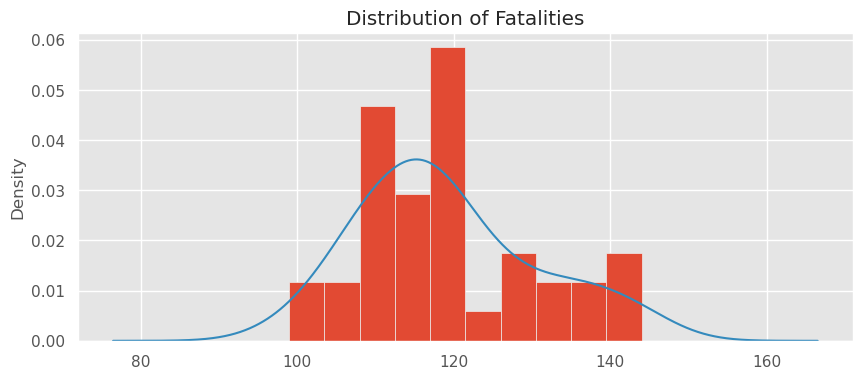

In [41]:
fig, ax = plt.subplots(figsize = (10,4))

model_test['fatalities'].plot(kind = "hist", density = True, bins = 10)
model_test['fatalities'].plot(kind='kde')
plt.title('Distribution of Fatalities');


## Exploring possible covariates

/tmp/ipykernel_24/3370163699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_plot['prev_spending'] = corr_plot.highway_spending.shift(1)


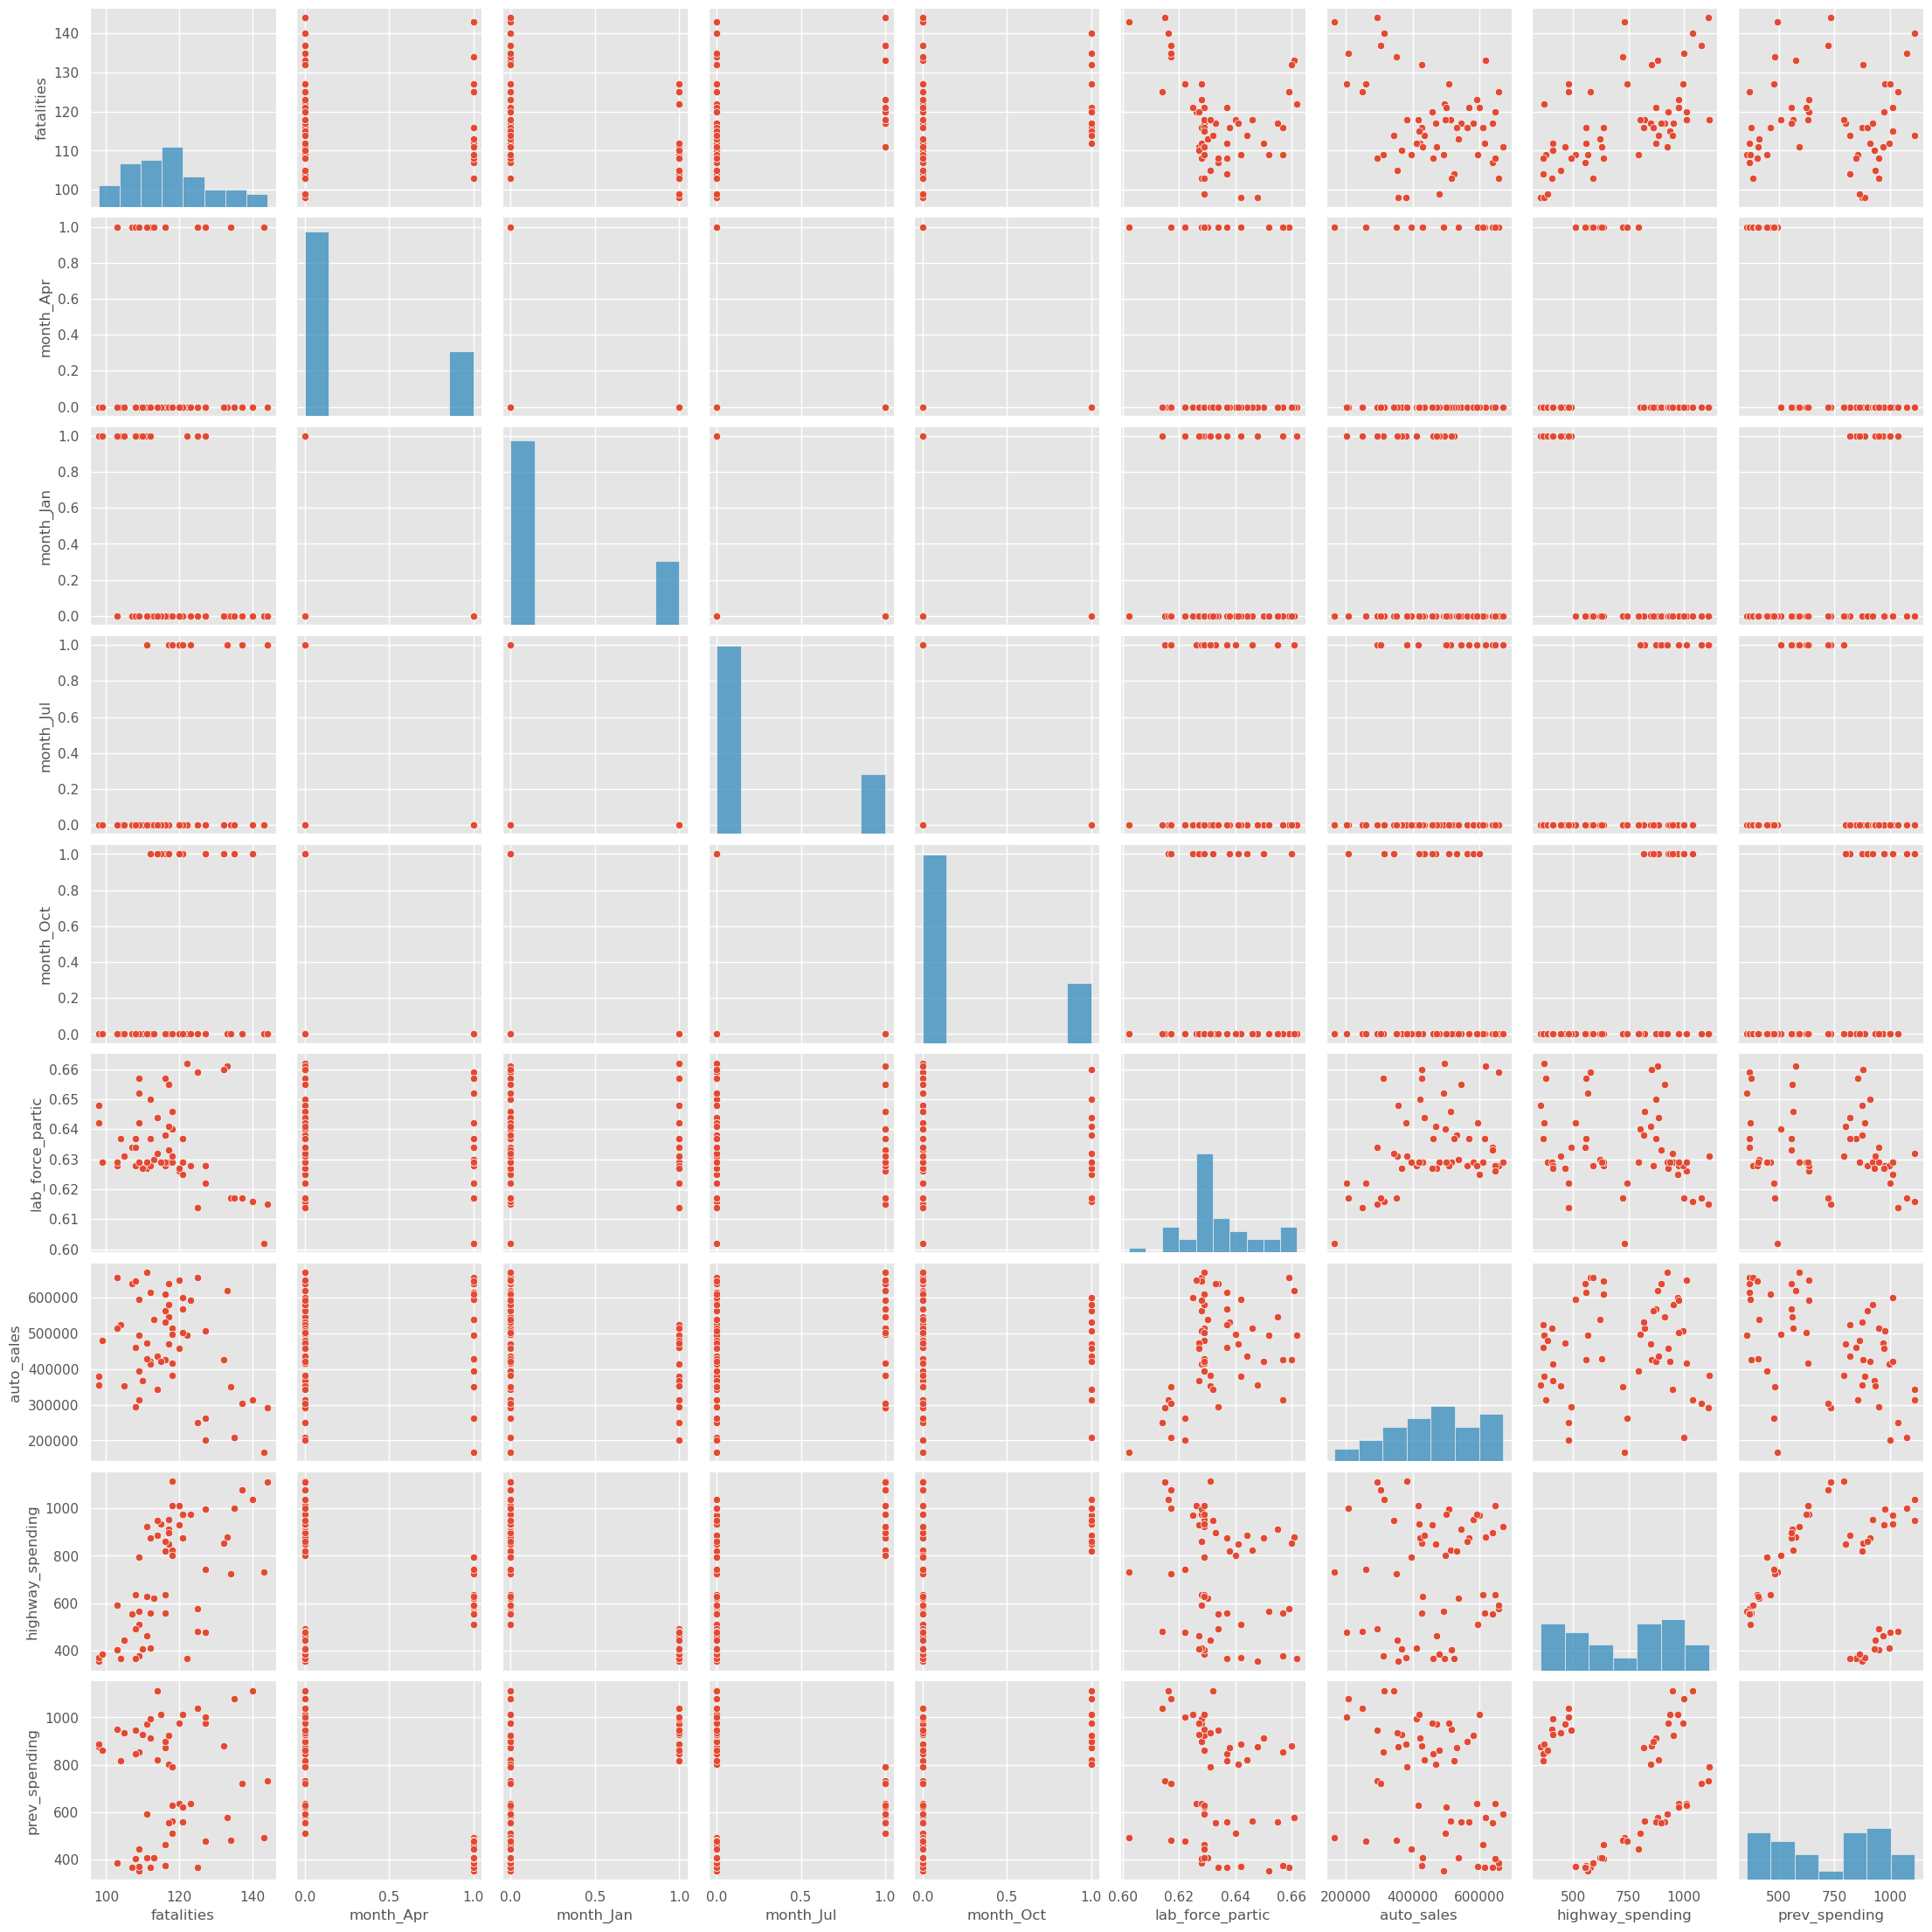

In [42]:
import seaborn as sns

corr_plot = fatalities[['fatalities', 'month_Apr', 'month_Jan', 'month_Jul','month_Oct', 
                        'lab_force_partic', 'auto_sales', 'highway_spending']]
corr_plot['prev_spending'] = corr_plot.highway_spending.shift(1)
corr_plot
sns.pairplot(corr_plot)

## Using highway spending and labor force participation as covariates

In [43]:
import pymc3 as pm
import arviz as az
import statsmodels.api as sm

f_mod = fatalities.copy()
with pm.Model() as bayes_model:
    glm.GLM.from_formula('fatalities ~ highway_spending + lab_force_partic + month_Jan + month_Apr + month_Jul + month_Oct', model_test, family=glm.families.Poisson()) 
    # PYMC3 automatically uses exponential link function and adds an intercept term
    trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')

/tmp/ipykernel_24/575500179.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, month_Oct, month_Jul, month_Apr, month_Jan, lab_force_partic, highway_spending, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 193 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [44]:
bayes_model.basic_RVs

[Intercept ~ Flat,
 highway_spending ~ Normal,
 lab_force_partic ~ Normal,
 month_Jan ~ Normal,
 month_Apr ~ Normal,
 month_Jul ~ Normal,
 month_Oct ~ Normal,
 mu_log__ ~ TransformedDistribution,
 y ~ Poisson]

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


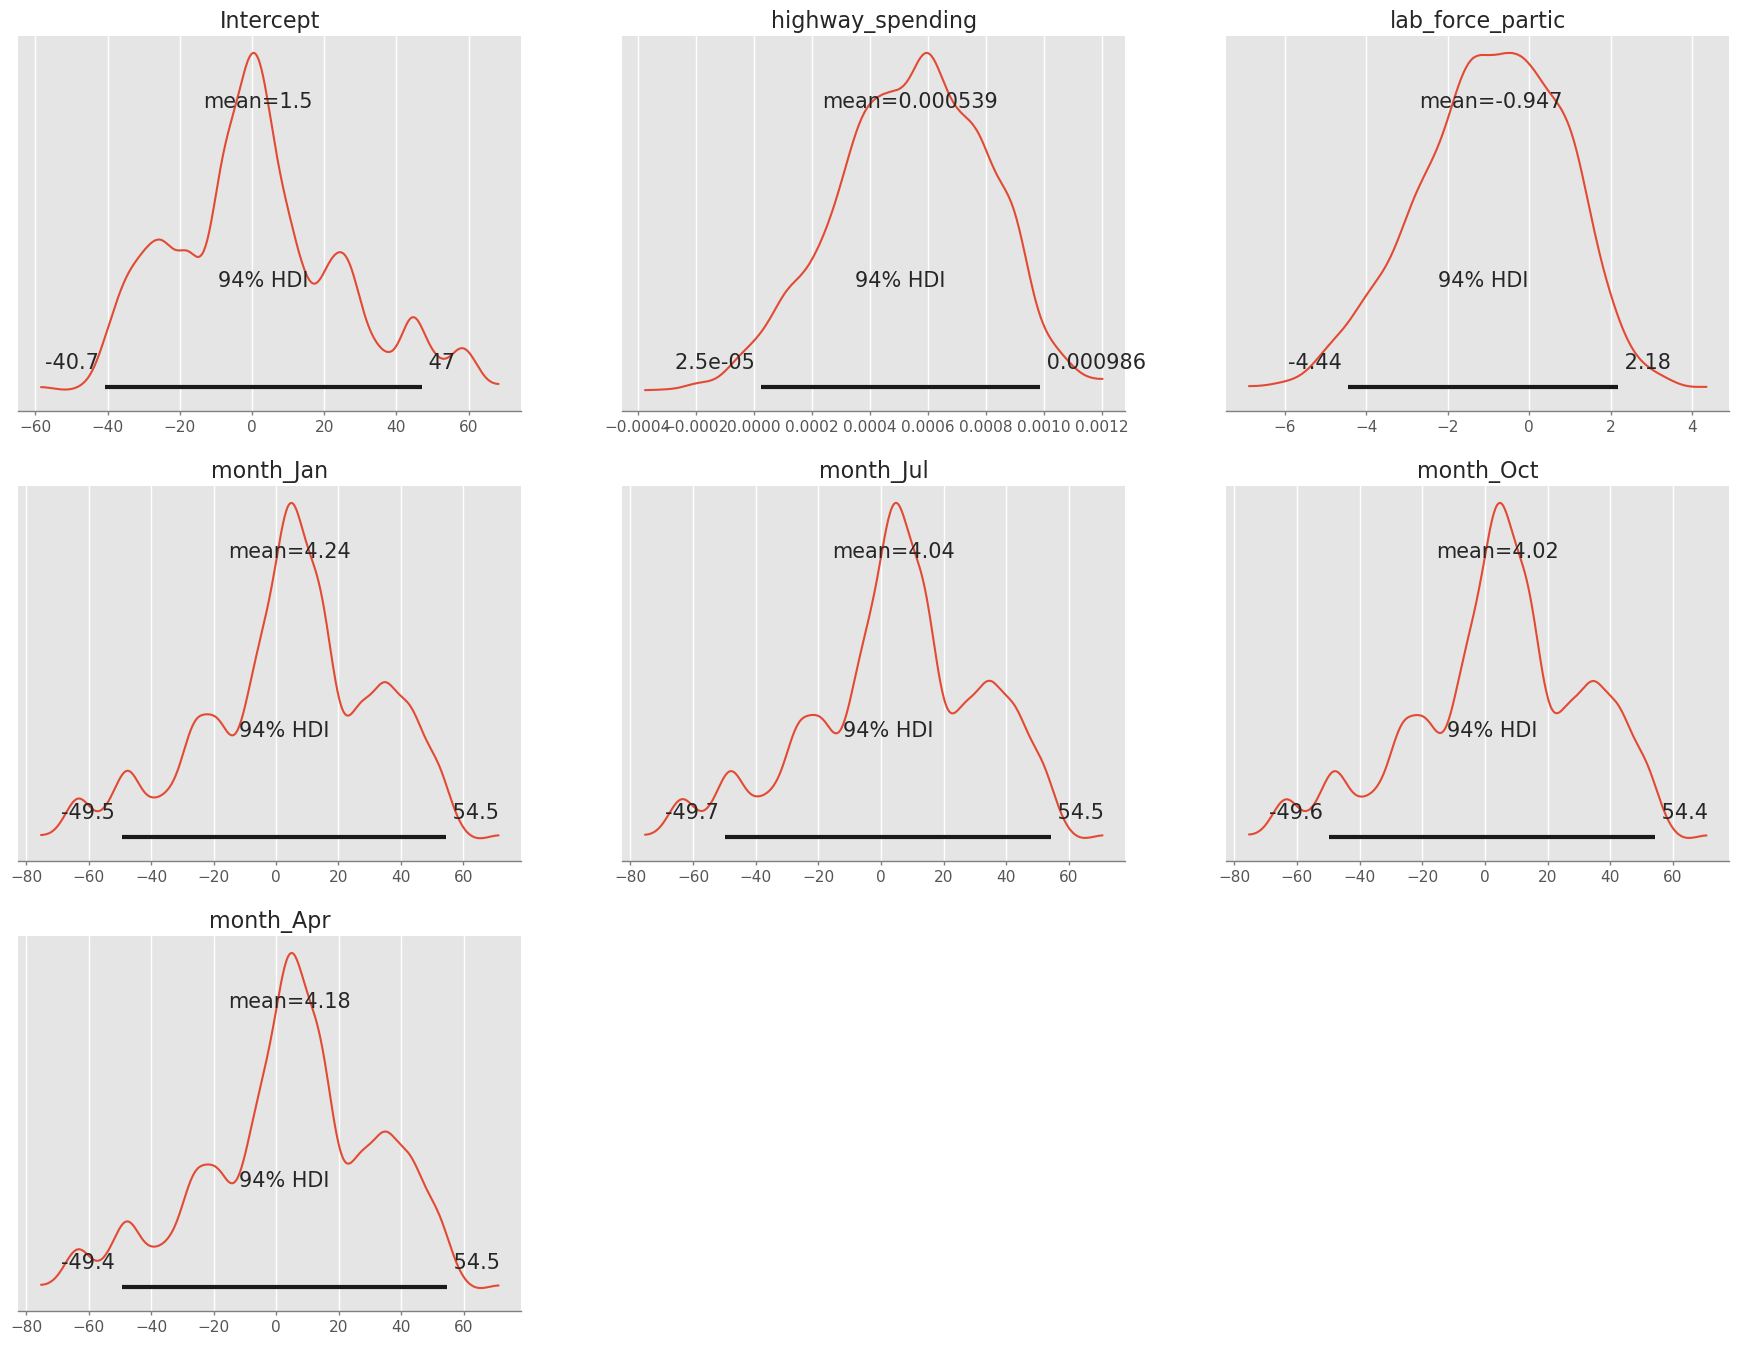

In [45]:
az.plot_posterior(trace_poisson, ['Intercept', 'highway_spending', 'lab_force_partic','month_Jan', 'month_Jul', 'month_Oct', 'month_Apr'], round_to = 3)
plt.show()

In [46]:
with pm.Model() as poisson_model:
    glm.GLM.from_formula('fatalities ~ highway_spending + lab_force_partic + month_Jan + month_Apr + month_Jul + month_Oct', model_test, family=glm.families.Poisson())
    # PYMC3 automatically uses exponential link function and adds an intercept term
    trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')

/tmp/ipykernel_24/2165990719.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, month_Oct, month_Jul, month_Apr, month_Jan, lab_force_partic, highway_spending, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 187 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


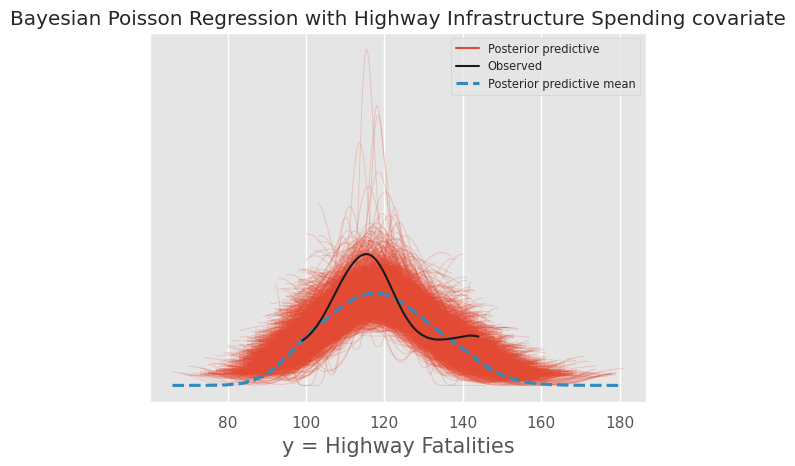

In [47]:
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(trace_poisson)
    poisson_ppc['y'] = poisson_ppc['y'] + 0.0
    ppc_poisson = az.from_pymc3(trace_poisson, posterior_predictive=poisson_ppc)
        
# Plot PPC samples

az.plot_ppc(ppc_poisson)
plt.xlabel('y = Highway Fatalities')
plt.title('Bayesian Poisson Regression with Highway Infrastructure Spending covariate')
# plt.axis([-2, 45, -0.01, 0.2])

plt.show()

In [48]:
# No TODOs here: Just inspect the code and make sure you understand what is happening
with pm.Model() as simple_bayes_model:
    mu = pm.Gamma('mu', alpha=10, beta=1)
    counts = pm.Poisson('C', mu=mu, observed=model_test.fatalities)
    simple_trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')

/tmp/ipykernel_24/3935007106.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  simple_trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.


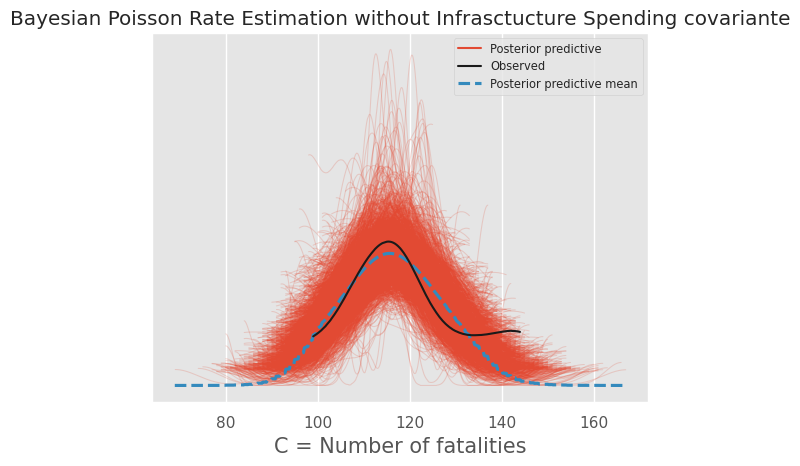

In [50]:
with simple_bayes_model:
        simple_bayes_ppc = pm.sample_posterior_predictive(simple_trace_poisson)
        simple_bayes_ppc['C'] = simple_bayes_ppc['C'] + 0.0

ppc_data = az.from_pymc3(simple_trace_poisson, posterior_predictive=simple_bayes_ppc)
az.plot_ppc(ppc_data)
plt.xlabel('C = Number of fatalities')
plt.title('Bayesian Poisson Rate Estimation without Infrasctucture Spending covariante')
plt.show()